In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from PIL import Image

from tqdm.notebook import tqdm

from utils_analysis import *
import torch
from torch.utils.data import DataLoader
import cv2
from skimage import data

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

CW2019で全てのbest headに含まれるうちでN2010のbest headが最も小さいものを探す．

In [3]:
training_methods = ["dino", "supervised"] 
depth_list = [8, 12]
num_models = 6
num_top = 5

imagenetの画像を256 x 256に変換．skimageの画像を付け足す．

In [4]:
#frame_indices = [83, 275, 690, 1000, 1500]
frame_indices = [300, 692]
# load frame
imgs = [Image.open("../dataset/Nakano_etal_2010/video_stimuli/frames/frame{0:04}.png".format(frame_idx)) for frame_idx in frame_indices]
blur_imgs = [Image.open("../figures/masked_frames/frame{0:04}_masked.png".format(frame_idx)) for frame_idx in frame_indices]
num_imgs = len(frame_indices)

In [5]:
attn_dict = np.load("../results/dino_vit_attention_groups_N2010.npz", allow_pickle=True)

In [6]:
attn_concat = np.vstack([attn_dict[str(depth)].reshape(72, num_imgs, -1) for depth in depth_list])
attn_concat_flat = attn_concat.reshape(144, num_imgs, -1)

In [7]:
labels = np.load("../results/attn_best_label_N2010.npy")

In [8]:
np.unique(labels, return_counts=True)

(array([1, 2, 3], dtype=int32), array([24, 28, 92]))

In [9]:
mds_dist_dict_list = []
path = ["../results/mds_dist_N2010_dim32.npz",
        "../results/mds_dist_CW2019_animation_dim32.npz",
        "../results/mds_dist_CW2019_nature_dim32.npz",
        "../results/mds_dist_CW2019_drama_dim32.npz",]
for p in path:
    mds_dist_dict_list.append(np.load(p, allow_pickle=True)["mds_dist"].item())

In [10]:
tm = training_methods[0]
d_label = np.array([[7,8],[9,10]]) - 1
mds_dist_list = []
for mds_dist_dict in mds_dist_dict_list:
    mds_dist_concat = []
    for i, depth in enumerate(depth_list):
        mds_dist = mds_dist_dict[tm][str(depth)]
        for j in range(2):
            mds_dist_concat.append(mds_dist[:, d_label[i,j]].flatten())
    
    mds_dist_concat = np.hstack(mds_dist_concat)
    mds_dist_list.append(mds_dist_concat)

In [11]:
mds_dist_list2 = np.array(mds_dist_list)

In [12]:
mds_ranking = np.argsort(np.argsort(mds_dist_list2, axis=1), axis=1)

In [13]:
np.argmin(np.sum(mds_dist_list2[1:], axis=0))
#np.argmin(np.sum(mds_ranking[:, labels == 1], axis=0))

134

In [14]:
mds_label1 = mds_dist_concat[labels == 1]

In [15]:
g_indices = np.arange(144).reshape(4, 6, 6)

In [16]:
g_indices

array([[[  0,   1,   2,   3,   4,   5],
        [  6,   7,   8,   9,  10,  11],
        [ 12,  13,  14,  15,  16,  17],
        [ 18,  19,  20,  21,  22,  23],
        [ 24,  25,  26,  27,  28,  29],
        [ 30,  31,  32,  33,  34,  35]],

       [[ 36,  37,  38,  39,  40,  41],
        [ 42,  43,  44,  45,  46,  47],
        [ 48,  49,  50,  51,  52,  53],
        [ 54,  55,  56,  57,  58,  59],
        [ 60,  61,  62,  63,  64,  65],
        [ 66,  67,  68,  69,  70,  71]],

       [[ 72,  73,  74,  75,  76,  77],
        [ 78,  79,  80,  81,  82,  83],
        [ 84,  85,  86,  87,  88,  89],
        [ 90,  91,  92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101],
        [102, 103, 104, 105, 106, 107]],

       [[108, 109, 110, 111, 112, 113],
        [114, 115, 116, 117, 118, 119],
        [120, 121, 122, 123, 124, 125],
        [126, 127, 128, 129, 130, 131],
        [132, 133, 134, 135, 136, 137],
        [138, 139, 140, 141, 142, 143]]])

In [17]:
#depth = 12
#attn_layer = attn_dict[str(depth)][-1, 3].reshape(-1, num_imgs, 30, 45)

depth = 8
attn_layer = attn_dict[str(depth)][-1, 1].reshape(-1, num_imgs, 30, 45)

In [18]:
#depth = 12
#attn_layer = attn_dict[str(depth)][-1, 4].reshape(-1, num_imgs, 30, 45)

In [19]:
attn_dict[str(depth)].shape

(2, 6, 6, 2, 1350)

In [20]:
attns = []
for i in range(1, 4):
    idx = np.where(labels == i)[0]
    attn = np.mean(attn_concat_flat[idx].reshape(-1, num_imgs, 30, 45), axis=0)
    attns.append(attn)

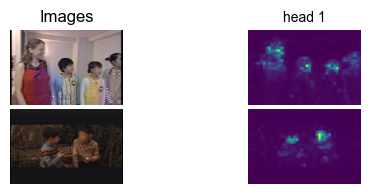

In [21]:
fig, axes = plt.subplots(num_imgs, 2, figsize=(6, 2))#, tight_layout=True)
for i in range(num_imgs):
    axes[i, 0].imshow(blur_imgs[i])
    #axes[i, 0].set_ylabel(str(i))
    #axes[i, 1].imshow(attn_layer[2, i])
    axes[i, 1].imshow(attn_layer[0, i])
for i in range(num_imgs):
    for j in range(2):
        axes[i, j].axis("off")
axes[0, 0].set_title("Images")
for j in range(1):
    axes[0, 1+j].set_title(f"head 1", fontsize=10)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.suptitle(f"DINO ViT-{depth}, layer #{d_idx+1}, model #{m_idx+1}")
#plt.tight_layout()
fig.savefig(f"../figures/example_attention_maps_N2010_2.svg", dpi=200)

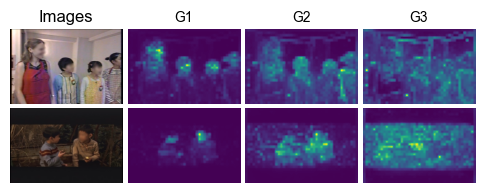

In [22]:
fig, axes = plt.subplots(num_imgs, 4, figsize=(6, 2))#, tight_layout=True)
for i in range(num_imgs):
    axes[i, 0].imshow(blur_imgs[i])
    #axes[i, 0].set_ylabel(str(i))
    for jj, j in enumerate([0, 2, 1]):
        axes[i, 1+jj].imshow(attns[j][i])
for i in range(num_imgs):
    for j in range(4):
        axes[i, j].axis("off")
axes[0, 0].set_title("Images")
for j in range(3):
    axes[0, 1+j].set_title(f"G{j+1}", fontsize=10)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.suptitle(f"DINO ViT-{depth}, layer #{d_idx+1}, model #{m_idx+1}")
#plt.tight_layout()
fig.savefig(f"../figures/example_attention_maps_N2010.svg", dpi=200)